# Replication 1 - Code

Here we solve the FWL model and do the graphics

First, install the packages you need and use "library()" to use them

In [ ]:
#libraries
#install.packages("tidyverse")
#install.packages("xtable")
#install.packages("sandwich")
#install.packages("ggplot2")
library(tidyverse)
library(xtable)
library(sandwich)
library(ggplot2)

Upload the data. You have the partial path version

In [ ]:
#load("../../data/wage2015_subsample_inference.Rdata")
#data=data %>%
#  filter(scl==1|clg==1|ad==1)
#attach(data)
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data <- read.csv(file)
attach(data)

The following objects are masked from data (pos = 3):

    ad, clg, exp1, exp2, exp3, exp4, hsg, ind, ind2, lwage, mw, ne,
    occ, occ2, scl, sex, shs, so, wage, we


The following objects are masked from data (pos = 4):

    ad, clg, exp1, exp2, exp3, exp4, hsg, ind, ind2, lwage, mw, ne,
    occ, occ2, scl, sex, shs, so, wage, we


The following objects are masked from data (pos = 5):

    ad, clg, exp1, exp2, exp3, exp4, hsg, ind, ind2, lwage, mw, ne,
    occ, occ2, scl, sex, shs, so, wage, we


The following objects are masked from data (pos = 6):

    ad, clg, exp1, exp2, exp3, exp4, hsg, ind, ind2, lwage, mw, ne,
    occ, occ2, scl, sex, shs, so, wage, we




#ITEM 1

Model without controls

Here we are going to see how big is the impact of being woman in the log wage.
Is the impact of woman because 1 is woman, so at the end, we see the effect of that

Log(Y)=b1*sex+e

In [ ]:
b1=lm(lwage~sex)
b1_est=summary(b1)$coef["sex",1]
HCV_coefs1=vcovHC(b1, type = 'HC');
se1=sqrt(diag(HCV_coefs1))[2]
cat("the beta estimated is",b1_est)

the beta estimated is -0.03834473

Controlling by scl, clg, ad, experience and so on, we have a new model.

Now, we are going to estimated the impact of sex in log wage, but controlling by education
level and the experience

Log(Y)=a1*sex+B'x+ey

In [ ]:
modelo <- lwage ~ sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+ad+occ2+ind2+mw+so+we)
a1=lm(modelo,data=data)
a1_est=summary(a1)$coef[2,1]
HCV_coefs2=vcovHC(a1, type = 'HC')
se2=sqrt(diag(HCV_coefs2))[2]
cat("the beta estimated, controlling by education and experience, is",a1_est)

the beta estimated, controlling by education and experience, is -0.1024693

Partialling out

In this part, as FWL said, the beta estimated controlling by variables (a1) have to be the same as the beta estimated in the model of the impact of the errors between sex and the controls in the errors of the PGD

ey=esex*c1+v

In [ ]:
modelo_y=lwage ~  (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+ad+occ2+ind2+mw+so+we)
modelo_sex=sex ~ (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+ad+occ2+ind2+mw+so+we)
error_y=lm(modelo_y,data=data)$res
error_sex=lm(modelo_sex,data=data)$res
c1=lm(error_y~error_sex)
c1_est=summary(c1)$coef[2,1]
HCV.coefs <- vcovHC(c1, type = 'HC')
se3 <- sqrt(diag(HCV.coefs))[2]
confint(c1)[2,]
cat("the beta estimated, for the residuals, is",c1_est)

2.5 %      97.5 % 
-0.13102916 -0.07390946

the beta estimated, for the residuals, is -0.1024693

Table of the betas and se

In [ ]:
table<- matrix(0, 3, 2)
table[1,1]<- b1_est
table[1,2]<- se1
table[2,1]<- a1_est
table[2,2]<- se2
table[3,1]<- c1_est
table[3,2]<- se3

colnames(table)<- c("Estimate","Std. Error")
rownames(table)<- c("Without controls", "full reg", "partial reg")
tab<- xtable(table, digits=c(3, 3, 4))
tab

,Estimate,Std. Error
,<dbl>,<dbl>
Without controls,-0.03834473,0.01590194
full reg,-0.10246931,0.01458860
partial reg,-0.10246931,0.01458860


#ITEM 2

Graphics

##Histogram-Wage

Wage per hour is under 100 dollars

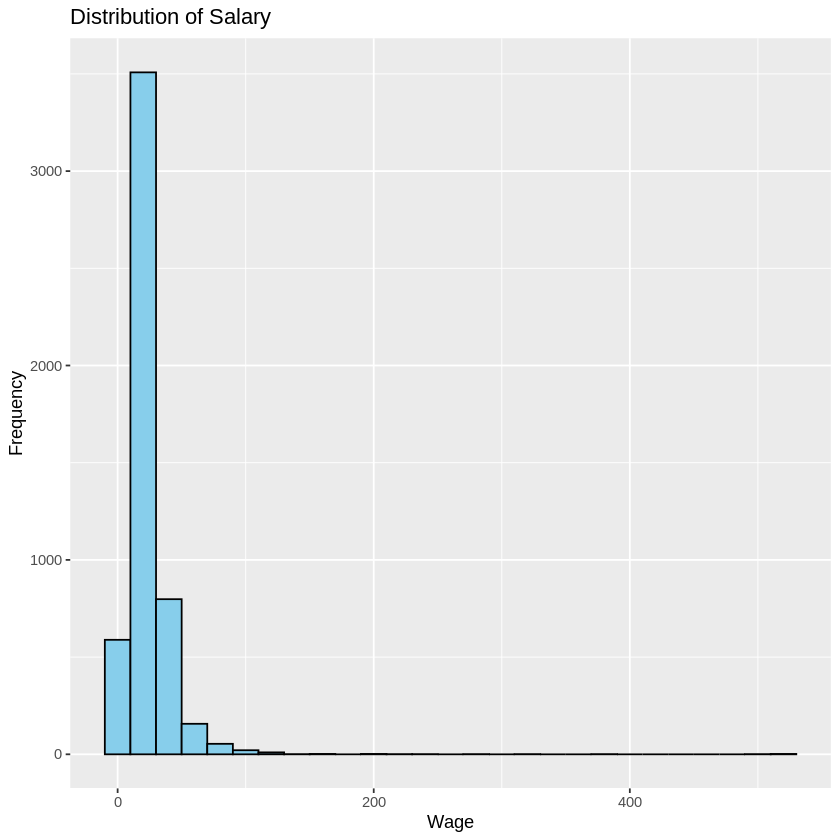

In [ ]:
hist_wage <- ggplot(data, aes(x = wage)) +
  geom_histogram(binwidth = 20,fill = "skyblue", color = "black") +
  labs(x = "Wage", y = "Frequency", title = "Distribution of Salary")
print(hist_wage)

##Histogram-Lwage

Log wage per hour

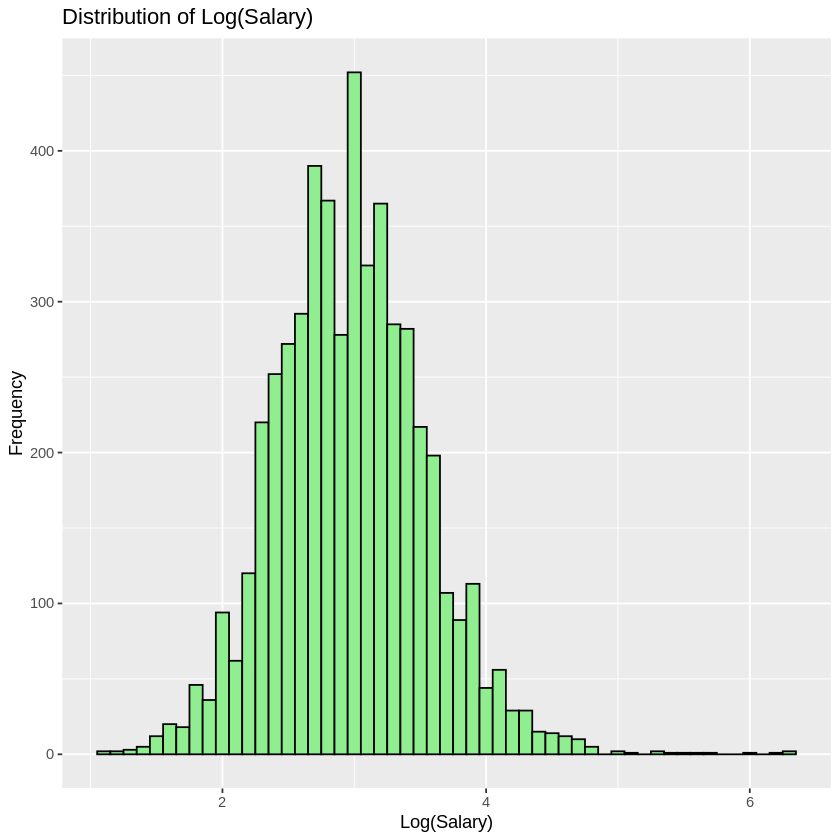

In [ ]:
hist_lwage <- ggplot(data, aes(x = lwage)) +
  geom_histogram(binwidth = 0.1, fill = "lightgreen", color = "black") +
  labs(x = "Log(Salary)", y = "Frequency", title = "Distribution of Log(Salary)")
print(hist_lwage)

##Pie-sex

Sex distribution-most of the sample are men, but in a little proportion




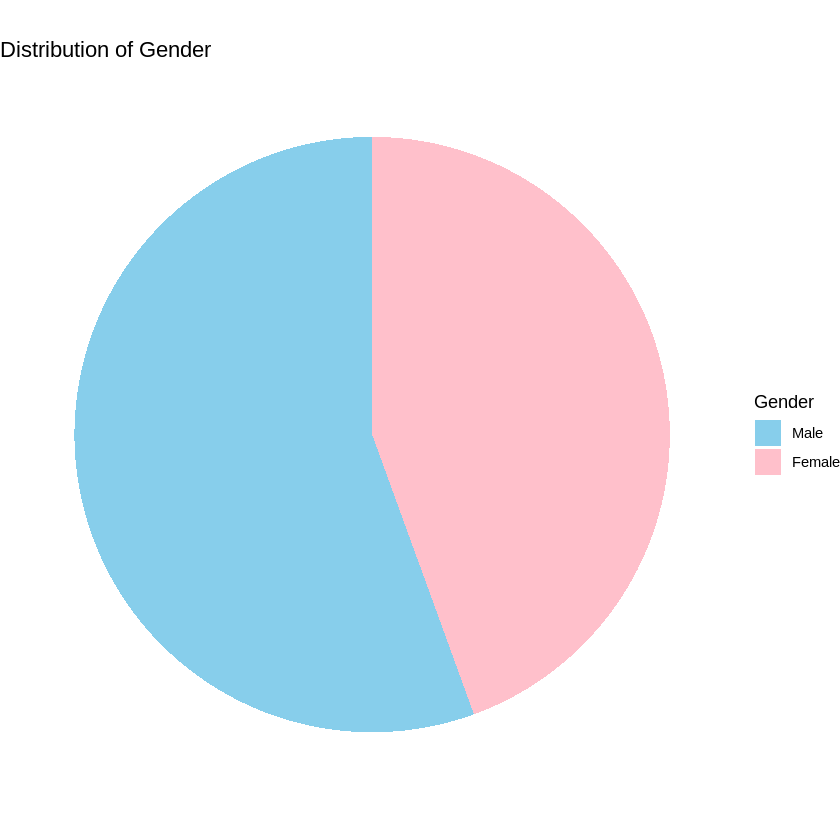

In [ ]:
pie_sex <- ggplot(data, aes(x = "", fill = as.factor(sex))) +
  geom_bar(width = 1) +
  coord_polar(theta = "y") +
  labs(fill = "Gender", title = "Distribution of Gender") +
  scale_fill_manual(values = c("0" = "skyblue", "1" = "pink"), labels = c("0" = "Male", "1" = "Female")) +
  theme_void() +
  theme(legend.position = "right")
print(pie_sex)

##Bar chart-education

In the sample, the biggest goup is on collage

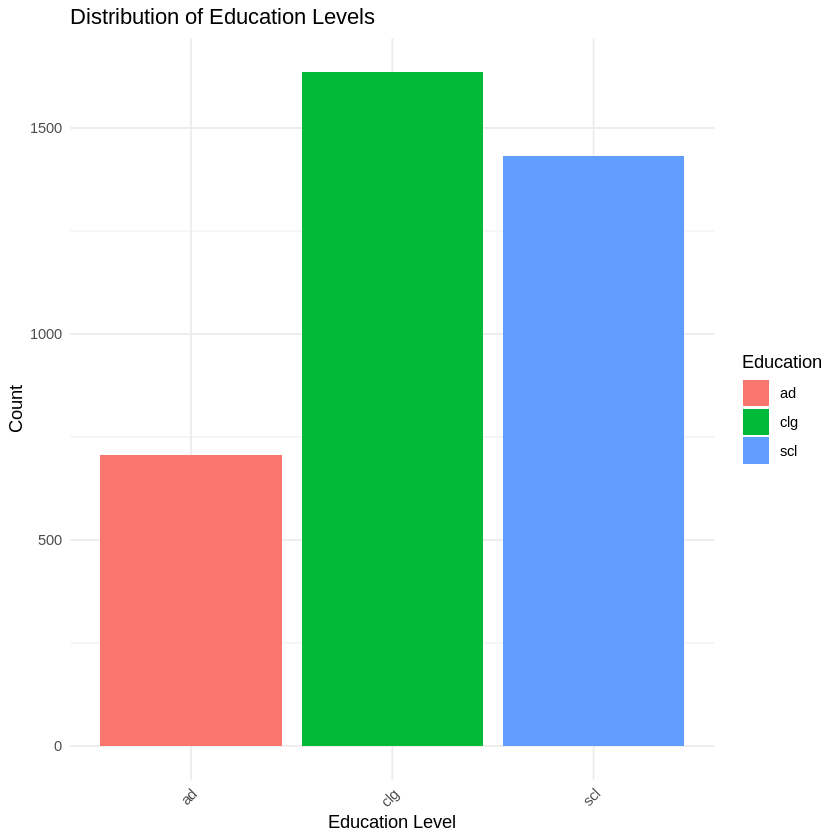

In [ ]:
education_counts <- data %>%
  select(scl, clg, ad) %>%
  pivot_longer(cols = everything(), names_to = "Education", values_to = "Count") %>%
  group_by(Education) %>%
  summarise(Total = sum(Count))
education_plot <- ggplot(education_counts, aes(x = Education, y = Total, fill = Education)) +
  geom_bar(stat = "identity") +
  labs(x = "Education Level", y = "Count", title = "Distribution of Education Levels") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(education_plot)

##Scatter plot-exp1-wage

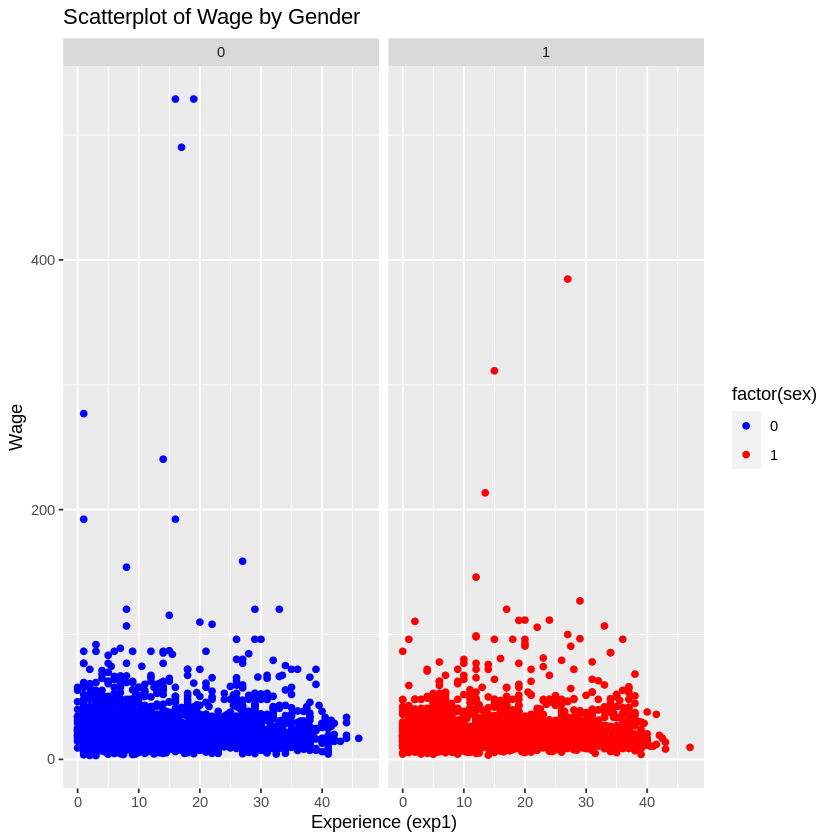

In [ ]:
scatterplot_wage <- ggplot(data, aes(x = exp1, y = wage, color = factor(sex))) +
  geom_point() +
  labs(x = "Experience (exp1)", y = "Wage", title = "Scatterplot of Wage by Gender") +
  scale_color_manual(values = c("blue", "red")) +
  facet_wrap(~ sex)
print(scatterplot_wage)

## Scatter plot-exp1-lwage

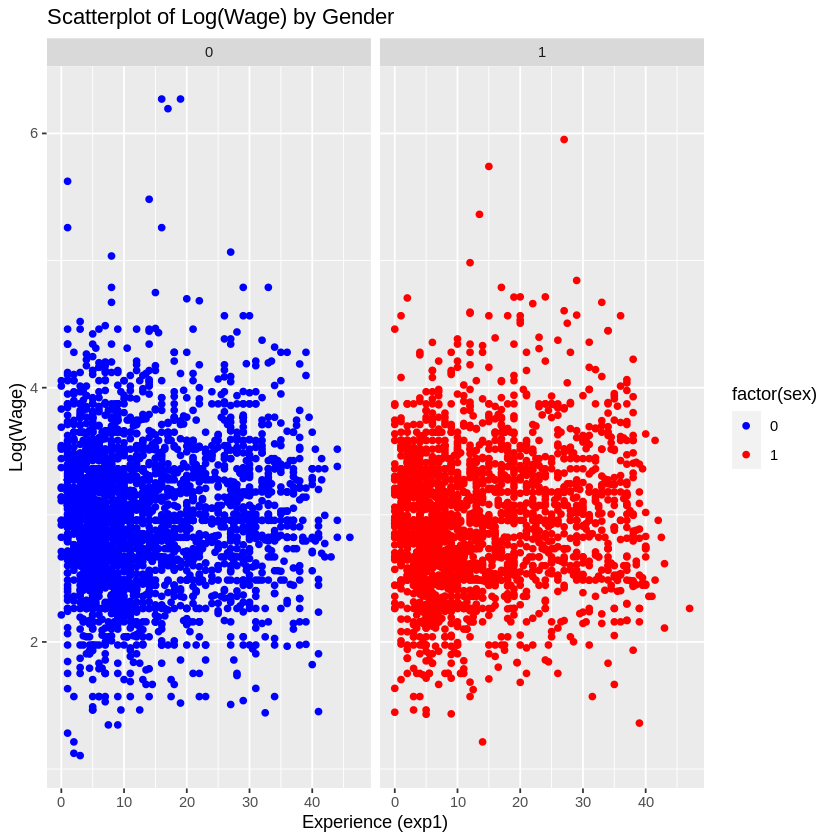

In [ ]:
scatterplot_lwage <- ggplot(data, aes(x = exp1, y = lwage, color = factor(sex))) +
  geom_point() +
  labs(x = "Experience (exp1)", y = "Log(Wage)", title = "Scatterplot of Log(Wage) by Gender") +
  scale_color_manual(values = c("blue", "red")) +
  facet_wrap(~ sex)
print(scatterplot_lwage)

#ITEM 3


##Confidence interval

In [ ]:
conf_intervals <- data.frame(
  Model = c("Without Controls", "Full Regression", "Partial Regression"),
  Coef = c(b1_est, a1_est, c1_est),
  Lower = c(b1_est - 1.96 * se1, a1_est - 1.96 * se2, c1_est - 1.96 * se3),
  Upper = c(b1_est + 1.96 * se1, a1_est + 1.96 * se2, c1_est + 1.96 * se3)
)
print(conf_intervals)

               Model        Coef       Lower        Upper
1   Without Controls -0.03834473 -0.06951253 -0.007176941
2    Full Regression -0.10246931 -0.13106296 -0.073875657
3 Partial Regression -0.10246931 -0.13106296 -0.073875657


##Graph

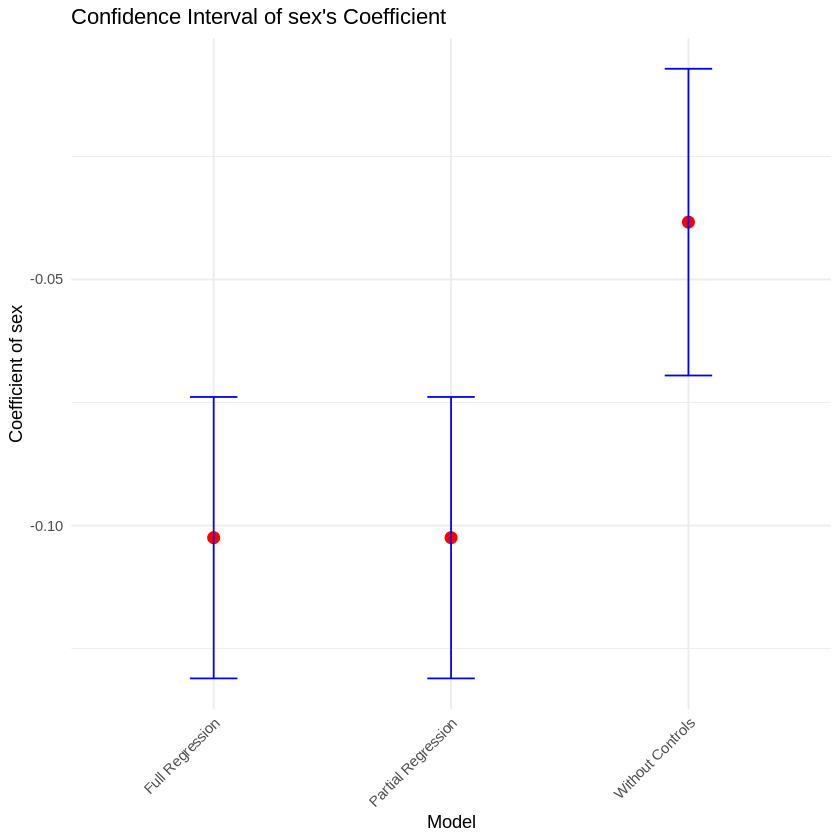

In [ ]:
confidence_plot <- ggplot(conf_intervals, aes(x = Model, y = Coef)) +
  geom_point(color = "red", size = 3) +
  geom_errorbar(aes(ymin = Lower, ymax = Upper), width = 0.2, color = "blue") +
  labs(x = "Model", y = "Coefficient of sex", title = "Confidence Interval of sex's Coefficient") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(confidence_plot)

#ITEM 4

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


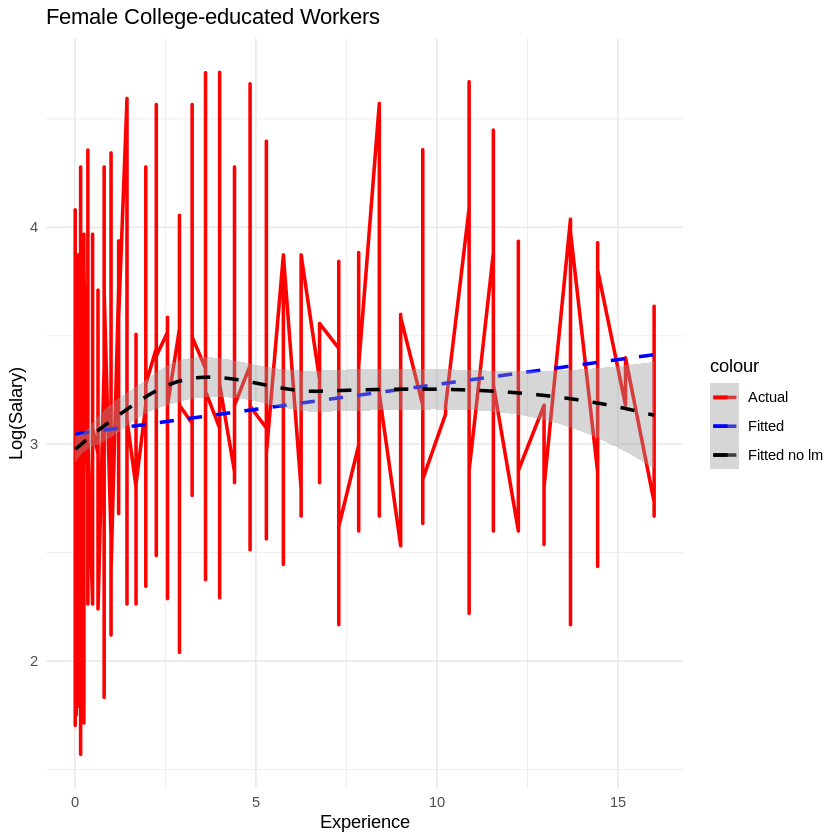

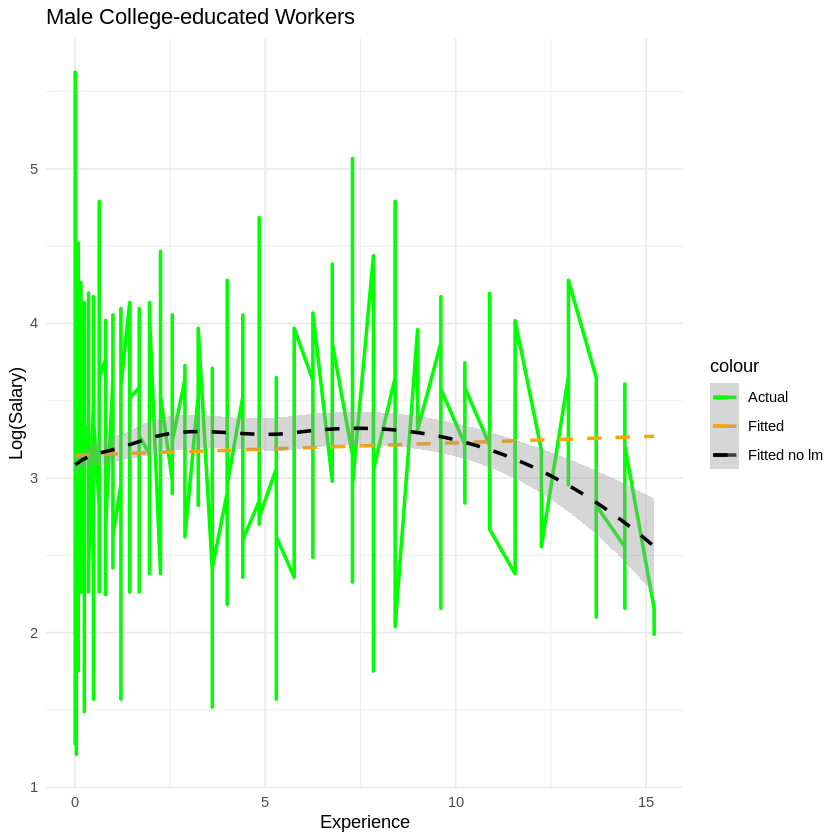

In [ ]:
# Filter clg==1
college_data <- data %>% filter(clg == 1)

# Graph femenine
female_college_data <- college_data %>% filter(sex == 1)
female_plot <- ggplot(female_college_data, aes(x = exp2, y = lwage)) +
  geom_line(aes(y = lwage, color = "Actual"), size = 1) +
  geom_line(aes(y = predict(lm(lwage ~ exp2)), color = "Fitted"), linetype = "dashed", size = 1) +
  labs(x = "Experience", y = "Log(Salary)", title = "Female College-educated Workers") +
  theme_minimal()+
  geom_smooth(aes(y = lwage, color="Fitted no lm"), se = TRUE, linetype = "dashed")+
  scale_color_manual(values = c("Actual" = "red", "Fitted" = "blue","Fitted no lm"="black"))
print(female_plot)

# Graph masculine
male_college_data <- college_data %>% filter(sex == 0)
male_plot <- ggplot(male_college_data, aes(x = exp2, y = lwage)) +
  geom_line(aes(y = lwage, color = "Actual"), size = 1) +
  geom_line(aes(y = predict(lm(lwage ~ exp2)), color = "Fitted"), linetype = "dashed", size = 1) +
  labs(x = "Experience", y = "Log(Salary)", title = "Male College-educated Workers") +
  theme_minimal()+
  geom_smooth(aes(y = lwage, color="Fitted no lm"), se = TRUE, linetype = "dashed")+
  scale_color_manual(values = c("Actual" = "green", "Fitted" = "orange","Fitted no lm"="black"))
print(male_plot)
